In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (150,150,100),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=5.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=50, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=3)

pos = 0.02

# test_phantom.add_tissue_sphere((pos,-pos,0), 2, blood)
# test_phantom.add_tissue_sphere((pos,0,0), 4, blood)
# test_phantom.add_tissue_sphere((pos,pos,0), 8, blood)

# test_phantom.add_tissue_sphere((-pos,n-pos,0), 4, fat)
# test_phantom.add_tissue_sphere((-pos,0,0), 8, fat)
# test_phantom.add_tissue_sphere((-pos,pos,0), 2, fat)

# test_phantom.add_tissue_sphere((0,-pos,0), 8, myocardium)
# test_phantom.add_tissue_sphere((0,0,0), 2, myocardium)
# test_phantom.add_tissue_sphere((0,pos,0), 4, myocardium)

test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
test_phantom.add_tissue_sphere((pos,0,0), 4, myocardium)
test_phantom.add_tissue_sphere((0+0.01,pos-0.01,0), 7, myocardium)
# test_phantom.add_tissue_sphere((-pos,2*pos,0), 6, myocardium)
test_phantom.set_default_tissue('fat')
test = test_phantom.get_complete()
# test_phantom.add_tissue_sphere((0,-pos,0), 4, myocardium)


1676


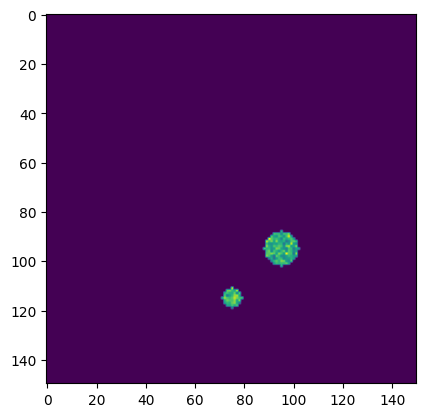

In [3]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])
x = test_phantom.mask
print(np.sum(np.where(x != 3, 1, 0)))


In [4]:
num_transducers = 3
transducers = [transducer.Planewave(max_frequency=1e6,
                                    elements = 32, 
                                    width = 20e-3,
                                    height =  10e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/6,
                                    ray_num = 30, 
                                    imaging_ndims = 2,
                                    focus_elevation = 50e-3,
                                    ) for i in range(num_transducers)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

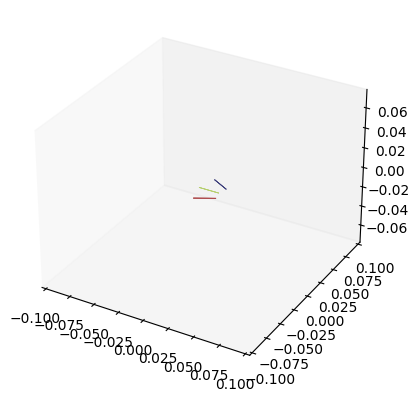

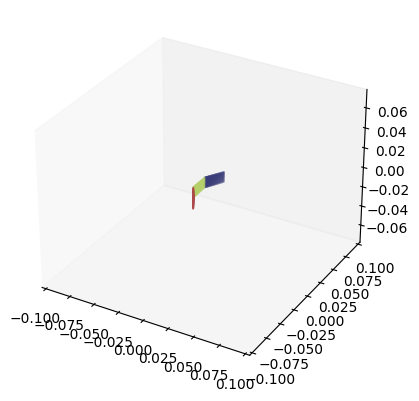

In [5]:
cont_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
cont_transducer_set.assign_pose(0, geometry.Transform([-np.pi/6,0,0], [0,0.01866,0]))
cont_transducer_set.assign_pose(2, geometry.Transform([np.pi/6,0,0], [0,-0.01866,0]))
cont_transducer_set.assign_pose(1, geometry.Transform(translation=[-0.005,0,0]))
# test_transducer_set.assign_pose(0, geometry.Transform([-2*np.pi/6,0,0], [0,0.01,0]))
# test_transducer_set.assign_pose(1, geometry.Transform([2*np.pi/6,0,0], [0,-0.01,0]))
# test_transducer_set.assign_pose(1, geometry.Transform([np.pi/20,0,0], [0,-0.01,0]))

cont_transducer_set.plot_transducer_fovs(scale=0.1)
cont_transducer_set.plot_transducer_coords(scale=0.1)

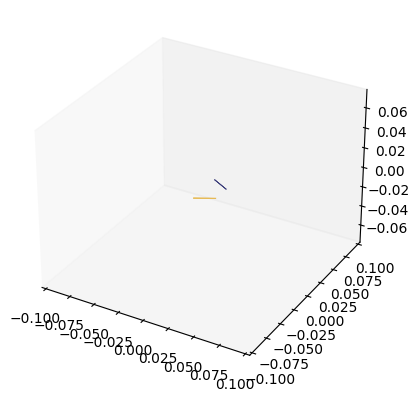

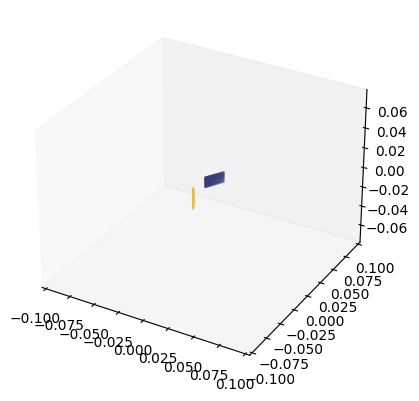

In [6]:
num_transducers = 2
transducers_copy = [transducer.Planewave(max_frequency=1e6,
                                    elements = 32, 
                                    width = 20e-3,
                                    height =  10e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/6,
                                    ray_num = 30, 
                                    imaging_ndims = 2,
                                    focus_elevation = 50e-3,
                                    ) for i in range(num_transducers)]

for t in transducers_copy:
    t.make_sensor_coords(test_phantom.baseline[0])
gap_transducer_set = transducer_set.TransducerSet(transducers_copy, seed=8888)
gap_transducer_set.assign_pose(0, geometry.Transform([-np.pi/6,0,0], [0,0.01866,0]))
gap_transducer_set.assign_pose(1, geometry.Transform([np.pi/6,0,0], [0,-0.01866,0]))

gap_transducer_set.plot_transducer_fovs(scale=0.1)
gap_transducer_set.plot_transducer_coords(scale=0.1)



In [7]:
extended_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='extended_aperture')
tar_sensor = sensor.Sensor(transducer_set=cont_transducer_set, aperture_type='transmit_as_receive')
gap_sensor = sensor.Sensor(transducer_set=gap_transducer_set, aperture_type='extended_aperture')

In [8]:
simprops = simulation.SimProperties(
                grid_size   = (80e-3,50e-3,30e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [9]:
extended_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/extended_aperture',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = extended_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = ['p_max']
                 )

tar_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/tar_aperture',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = cont_transducer_set,
                 sensor          = tar_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = ['p_max']
                 )

gap_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/gap_experiment_ea',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = gap_transducer_set,
                 sensor          = gap_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 2,
                 additional_keys = ['p_max']
                 )

extended_experiment.save()
tar_experiment.save()
gap_experiment.save()

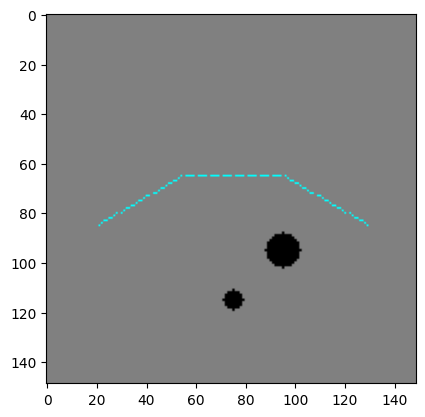

In [10]:
gm = extended_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2])

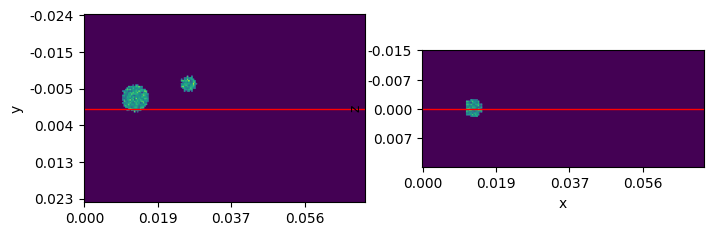

In [11]:
gap_experiment.plot_ray_path(0)

In [12]:
test_experiment = experiment.Experiment.load('../experiment_files/extended_aperture')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

dry run of simulation


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  9.83it/s]

running with 2 workers



preparation for sim    0 completed in  2.55 seconds
preparation for sim    1 completed in  2.55 seconds
preparation for sim    2 completed in  2.67 seconds
simulation             0 completed in  4.96 seconds
preparation for sim    3 completed in  2.49 seconds
preparation for sim    4 completed in  2.52 seconds
simulation             1 completed in  4.78 seconds
preparation for sim    5 completed in  2.48 seconds
preparation for sim    6 completed in  2.50 seconds
simulation             2 completed in  4.79 seconds
simulation             3 completed in  4.77 seconds
preparation for sim    7 completed in  2.45 seconds
preparation for sim    8 completed in  2.44 seconds
simulation             4 completed in  4.75 seconds
simulation             5 completed in  4.75 seconds
preparation for sim    9 completed in  2.52 seconds
simulation             6 completed in  4.82 seconds
preparation for sim   10 completed in  2.46 seconds
simulation             7 completed in  4.74 seconds
preparation 

In [6]:
test_experiment = experiment.Experiment.load('../experiment_files/tar_aperture')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

dry run of simulation


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 11.55it/s]

running with 2 workers



preparation for sim    0 completed in  2.53 seconds
preparation for sim    1 completed in  2.49 seconds
preparation for sim    2 completed in  2.52 seconds
simulation             0 completed in  4.54 seconds
preparation for sim    3 completed in  2.39 seconds
preparation for sim    4 completed in  2.44 seconds
simulation             1 completed in  4.64 seconds
preparation for sim    5 completed in  2.45 seconds
simulation             2 completed in  4.39 seconds
preparation for sim    6 completed in  2.42 seconds
preparation for sim    7 completed in  2.53 seconds
simulation             3 completed in  4.64 seconds
simulation             4 completed in  4.34 seconds
preparation for sim    8 completed in  2.43 seconds
preparation for sim    9 completed in  2.50 seconds
simulation             5 completed in  4.60 seconds
simulation             6 completed in  4.32 seconds
preparation for sim   10 completed in  2.41 seconds
preparation for sim   11 completed in  2.44 seconds
simulation  

In [7]:
test_experiment = experiment.Experiment.load('../experiment_files/gap_experiment_ea')
test_experiment.run(dry=True)
test_experiment.run(repeat=True)

dry run of simulation


100%|██████████| 2/2 [00:00<00:00, 12.53it/s]

running with 2 workers



preparation for sim    0 completed in  2.53 seconds
preparation for sim    1 completed in  2.68 seconds
preparation for sim    2 completed in  2.58 seconds
simulation             0 completed in  4.94 seconds
preparation for sim    3 completed in  2.46 seconds
preparation for sim    4 completed in  2.50 seconds
simulation             1 completed in  4.65 seconds
preparation for sim    5 completed in  2.58 seconds
preparation for sim    6 completed in  2.48 seconds
simulation             2 completed in  4.93 seconds
simulation             3 completed in  4.75 seconds
preparation for sim    7 completed in  2.63 seconds
preparation for sim    8 completed in  2.47 seconds
simulation             4 completed in  5.16 seconds
simulation             5 completed in  4.81 seconds
preparation for sim    9 completed in  2.49 seconds
preparation for sim   10 completed in  2.48 seconds
simulation             6 completed in  4.83 seconds
simulation             7 completed in  4.82 seconds
preparation 

# Reconstruction

In [3]:
test_experiment = experiment.Experiment.load('../experiment_files/tar_aperture')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 11.76it/s]


In [4]:
images1 = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True, combine=False)

100%|██████████| 90/90 [00:00<00:00, 867787.03it/s]


In [5]:
image1 = np.sum(images1, axis=0)
image1t1 = np.sum(images1[:len(images1)//3], axis=0)
image1t2 = np.sum(images1[len(images1)//3:2*len(images1)//3], axis=0)
image1t3 = np.sum(images1[2*len(images1)//3:], axis=0)

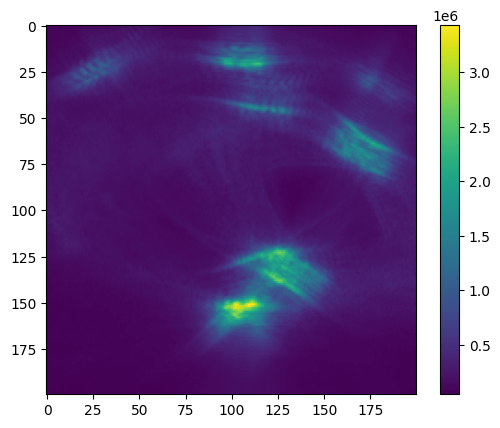

In [6]:
plt.imshow(image1[:,:,image1.shape[2]//2])
plt.colorbar()

In [32]:
test_experiment = experiment.Experiment.load('../experiment_files/extended_aperture')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


 33%|███▎      | 1/3 [00:00<00:00,  5.49it/s]

100%|██████████| 3/3 [00:00<00:00,  8.38it/s]


In [33]:
image2 = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True)

100%|██████████| 90/90 [00:00<00:00, 594468.28it/s]


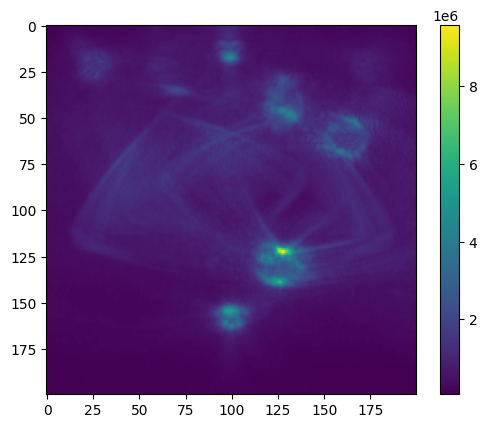

In [34]:
plt.imshow(image2[:,:,image2.shape[2]//2])
plt.colorbar()

In [35]:
test_experiment = experiment.Experiment.load('../experiment_files/gap_experiment_ea')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 2/2 [00:00<00:00, 12.27it/s]


In [36]:
image3 = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True)

100%|██████████| 60/60 [00:00<00:00, 827823.16it/s]


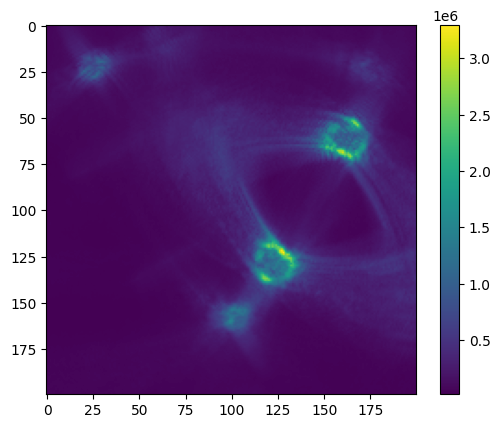

In [37]:
plt.imshow(image3[:,:,image3.shape[2]//2])
plt.colorbar()

In [19]:
pfield = utils.load_array('1mhz_pfield.npz')

In [39]:
test_experiment = experiment.Experiment.load('../experiment_files/tar_aperture')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


 33%|███▎      | 1/3 [00:00<00:00,  7.81it/s]

100%|██████████| 3/3 [00:00<00:00, 11.74it/s]


In [25]:
images1_ap = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True, combine=False, pressure_field=pfield)

100%|██████████| 90/90 [00:00<00:00, 692637.36it/s]


In [32]:
image1_ap = np.sum(images1_ap, axis=0)
image1t1_ap = np.sum(images1_ap[:len(images1_ap)//3], axis=0)
image1t2_ap = np.sum(images1_ap[len(images1_ap)//3:2*len(images1_ap)//3], axis=0)
image1t3_ap = np.sum(images1_ap[2*len(images1_ap)//3:], axis=0)

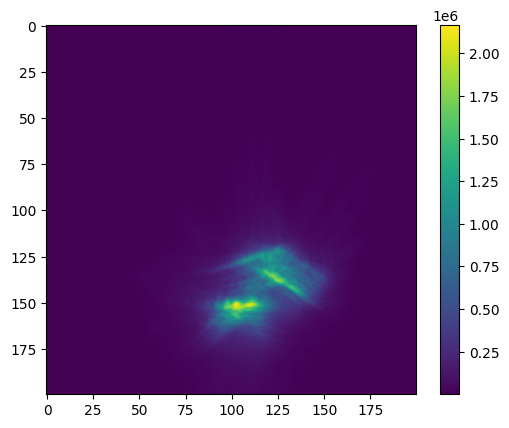

In [33]:
plt.imshow(image1_ap[:,:,image1_ap.shape[2]//2])
plt.colorbar()

In [42]:
test_experiment = experiment.Experiment.load('../experiment_files/extended_aperture')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  8.77it/s]


In [43]:
image2_ap = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True, pressure_field=pfield)

100%|██████████| 90/90 [00:00<00:00, 1266736.11it/s]


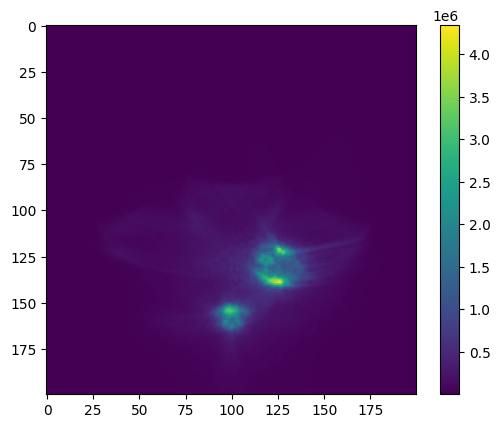

In [44]:
plt.imshow(image2_ap[:,:,image2_ap.shape[2]//2])
plt.colorbar()

In [45]:
test_experiment = experiment.Experiment.load('../experiment_files/gap_experiment_ea')
test_experiment.run(dry=True)
test_experiment.add_results()
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

dry run of simulation


100%|██████████| 2/2 [00:00<00:00, 12.84it/s]


In [46]:
image3_ap = test_reconstruction.compound(workers=24, resolution_multiplier=2, local=True, pressure_field=pfield)

100%|██████████| 60/60 [00:00<00:00, 1057387.56it/s]


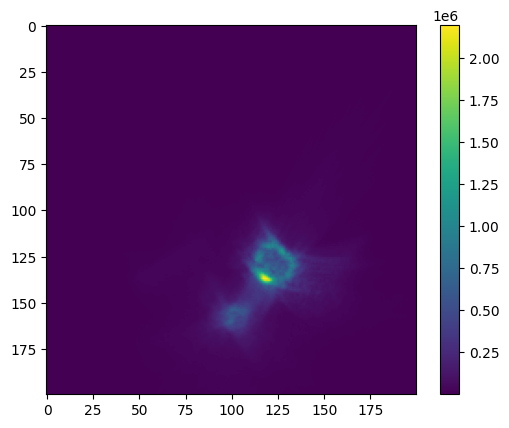

In [47]:
plt.imshow(image3_ap[:,:,image3_ap.shape[2]//2])
plt.colorbar()

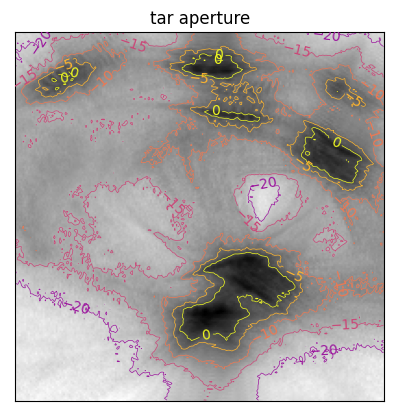

In [111]:
psf = 20 * np.log10(image1 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('tar aperture')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('two_spheres_tar_aperture.png', dpi=300)

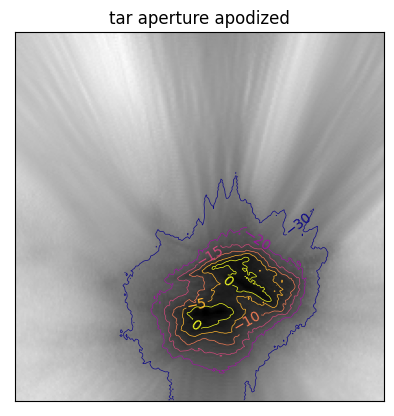

In [34]:
psf = 20 * np.log10(image1_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('tar aperture apodized')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('two_spheres_tar_aperture_apodized.png', dpi=300)

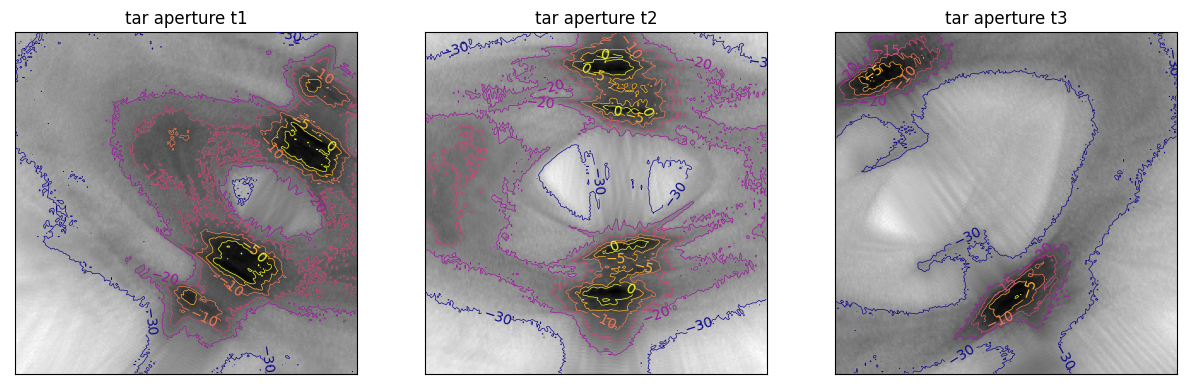

In [35]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

psf = 20 * np.log10(image1t1 / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[0].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[0].contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax[0].clabel(CS, inline=True, fontsize=10)
ax[0].set_title('tar aperture t1')
ax[0].set_xticks([])
ax[0].set_yticks([])

psf = 20 * np.log10(image1t2 / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[1].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[1].contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax[1].clabel(CS, inline=True, fontsize=10)
ax[1].set_title('tar aperture t2')
ax[1].set_xticks([])
ax[1].set_yticks([])

psf = 20 * np.log10(image1t3 / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[2].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[2].contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax[2].clabel(CS, inline=True, fontsize=10)
ax[2].set_title('tar aperture t3')
ax[2].set_xticks([])
ax[2].set_yticks([])



plt.savefig('two_spheres_tar_aperture_components.png', dpi=300)

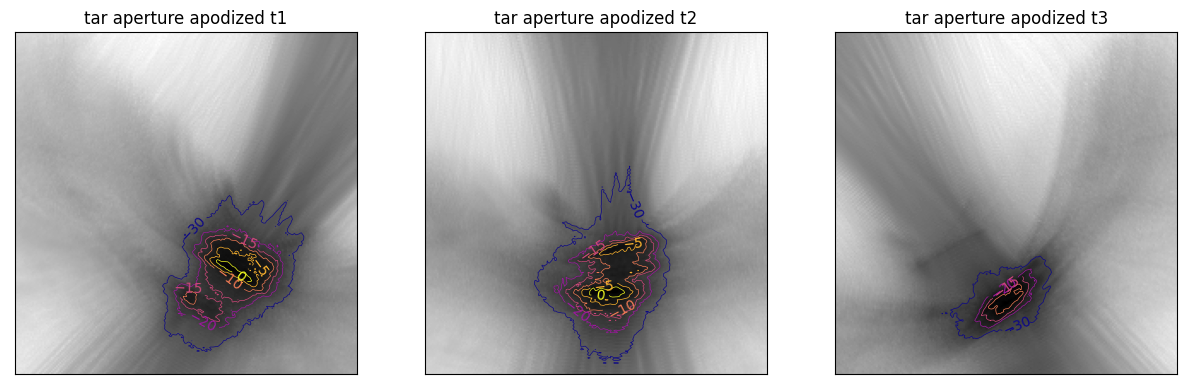

In [36]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

psf = 20 * np.log10(image1t1_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[0].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[0].contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax[0].clabel(CS, inline=True, fontsize=10)
ax[0].set_title('tar aperture apodized t1')
ax[0].set_xticks([])
ax[0].set_yticks([])

psf = 20 * np.log10(image1t2_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[1].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[1].contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax[1].clabel(CS, inline=True, fontsize=10)
ax[1].set_title('tar aperture apodized t2')
ax[1].set_xticks([])
ax[1].set_yticks([])

psf = 20 * np.log10(image1t3_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

ax[2].imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax[2].contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax[2].clabel(CS, inline=True, fontsize=10)
ax[2].set_title('tar aperture apodized t3')
ax[2].set_xticks([])
ax[2].set_yticks([])



plt.savefig('two_spheres_tar_aperture_apodized_components.png', dpi=300)

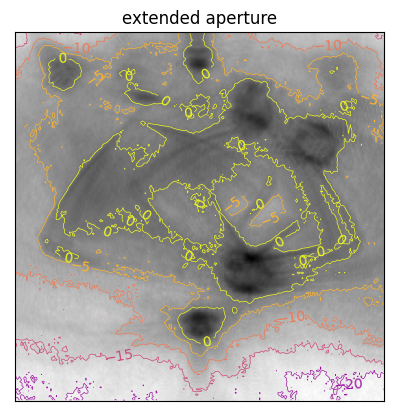

In [112]:
psf = 20 * np.log10(image2 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('extended aperture')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('two_spheres_extended_aperture.png', dpi=300)

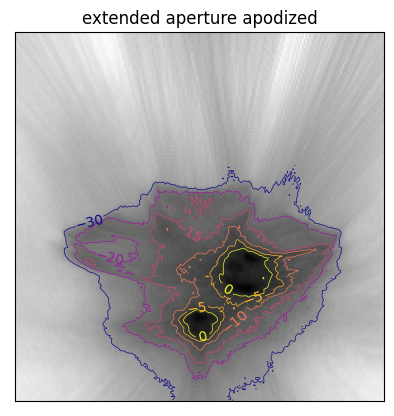

In [108]:
psf = 20 * np.log10(image2_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('extended aperture apodized')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('two_spheres_extended_aperture_apodized.png', dpi=300)

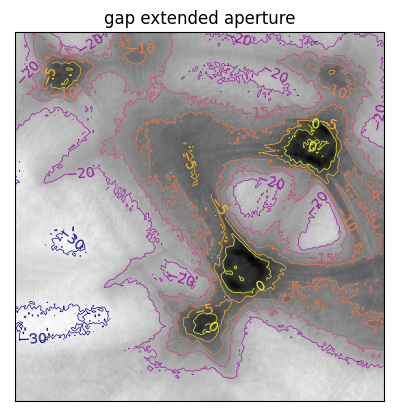

In [113]:
psf = 20 * np.log10(image3 / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('gap extended aperture')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('two_spheres_gap_extended_aperture.png', dpi=300)

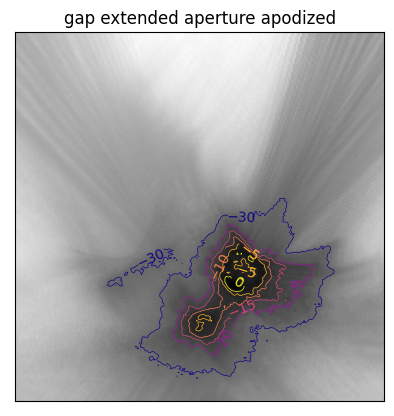

In [109]:
psf = 20 * np.log10(image3_ap / 1000000)
image = psf[:,:,psf.shape[2]//2]

fig, ax = plt.subplots()

ax.imshow(image, cmap='gray_r')
gridshape = test_reconstruction.phantom.matrix_dims * test_reconstruction.phantom.voxel_dims
x = np.linspace(-gridshape[0]//2, gridshape[0]//2, image.shape[0])
y = np.linspace(-gridshape[1]//2, gridshape[1]//2, image.shape[1])
X, Y = np.meshgrid(x, y)
CS = ax.contour(image, cmap='plasma', linewidths=0.5, levels = [-30,-20,-15,-10,-5,0,])
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('gap extended aperture apodized')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('two_spheres_gap_extended_aperture_apodized.png', dpi=300)